In [46]:
# Imports, as always...
from os import path
import numpy as np
import pandas as pd
import warnings
from tqdm.notebook import tqdm
from qiskit import qpy
from scipy.spatial.distance import jensenshannon

# Backends
from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeRomeV2, FakeLimaV2, FakeLondonV2, FakeYorktownV2, FakeMelbourneV2, FakeHanoiV2

# Dimensionality reduction and projection imports.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Scripts.
from scipts.circuit import generate_brickwork_circuit
from scipts.simulation import measurement_step_routine, depth_varied_routine

# Plotting.
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Version control.
from qiskit import __version__ as qiskit_version
from qiskit_ibm_runtime import __version__ as runtime_version
from sklearn import __version__ as sklearn_version

# Styling.
sns.set_context('paper')
sns.set_theme(style='darkgrid', palette='Dark2')

# Ignore warnings.
warnings.filterwarnings('ignore')

# RNG.
seed = 42

# Important package versions.
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit-ibm-runtime', runtime_version), ('numpy', np.__version__), ('sklearn', sklearn_version)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')

Important Package Versions...

qiskit             : 1.1.1
qiskit-ibm-runtime : 0.25.0
numpy              : 1.26.4
sklearn            : 1.5.1


In [2]:
# List of backends (devices) to generate data for.
backends = [FakeAthensV2(), FakeRomeV2(), FakeLimaV2(), FakeLondonV2(), FakeYorktownV2(), FakeMelbourneV2(), FakeHanoiV2()]

# Simulated Fingerprinting

Before we send to real devices, we would like to simulate the experimentation and run machine learning methods on them to understand how much data we'll be needing, and what we can probably do with it. We should also get a good idea for what kind of results we'll be looking at.

## Data Generation

In [3]:
# Depth-varied data generation.
for backend in tqdm(backends, desc='Generating data for backends'):
    depth_varied_routine(
        n=5, # This has to be odd... don't ask. 
        ds=np.arange(start=8, stop=21, step=4), 
        backend=backend,
        n_runs=100,
        n_shots=1000,
        write_to_file=True,
        seed=seed
    )

Generating data for backends:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
# Brickwork circuit.
brickwork_circuit = generate_brickwork_circuit(n=5, d=4, seed=seed)

# Measurement-step data generation.
for backend in tqdm(backends, desc='Generating data for backends'):
    measurement_step_routine(
        brickwork_circuit=brickwork_circuit,
        backend=backend,
        k=32,
        n_runs=100,
        n_shots=1000,
        write_to_file=True,
        seed=seed
    )

Generating data for backends:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# Save the circuit. 
with open('./data/fake-backend/brickwork-circuit.qpy', 'wb') as file:
    qpy.dump(brickwork_circuit, file)

## Data Reading

In [7]:
# Read in depth-varied data.
depth_varied_df = pd.concat([
    pd.read_csv(path.join('./data/fake-backend', backend.name, 'depth-varied-(2024-07-24).csv'))
    for backend in backends
]).fillna(0)

depth_varied_df

,n,d,run,n_shots,device,00000,00001,00010,00011,00100,...,10110,10111,11000,11001,11010,11011,11100,11101,11110,11111
0,5,8,1,1000,fake_athens,0.037,0.028,0.031,0.040,0.038,...,0.023,0.026,0.029,0.031,0.032,0.030,0.034,0.032,0.023,0.032
1,5,8,2,1000,fake_athens,0.034,0.042,0.036,0.039,0.026,...,0.028,0.024,0.028,0.025,0.030,0.034,0.027,0.028,0.029,0.032
2,5,8,3,1000,fake_athens,0.037,0.029,0.032,0.037,0.028,...,0.034,0.034,0.026,0.034,0.030,0.033,0.027,0.038,0.022,0.026
3,5,8,4,1000,fake_athens,0.040,0.042,0.030,0.038,0.032,...,0.028,0.039,0.035,0.028,0.032,0.034,0.021,0.029,0.025,0.031
4,5,8,5,1000,fake_athens,0.037,0.042,0.044,0.022,0.033,...,0.032,0.032,0.030,0.026,0.032,0.029,0.024,0.030,0.036,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,5,20,96,1000,fake_hanoi,0.038,0.024,0.035,0.029,0.028,...,0.035,0.037,0.033,0.032,0.028,0.034,0.025,0.033,0.036,0.039
396,5,20,97,1000,fake_hanoi,0.031,0.045,0.031,0.033,0.027,...,0.031,0.033,0.038,0.030,0.038,0.043,0.029,0.026,0.023,0.040
397,5,20,98,1000,fake_hanoi,0.027,0.039,0.026,0.030,0.038,...,0.021,0.028,0.028,0.033,0.030,0.038,0.034,0.022,0.026,0.038
398,5,20,99,1000,fake_hanoi,0.046,0.040,0.024,0.028,0.037,...,0.021,0.022,0.035,0.027,0.036,0.030,0.027,0.041,0.041,0.027


In [8]:
# Read in measurement-step data.
measurement_step_df = pd.concat([
    pd.read_csv(path.join('./data/fake-backend', backend.name, 'measurement-step-(2024-07-24).csv'))
    for backend in backends
]).fillna(0)

measurement_step_df

,n,d,step,k,run,n_shots,device,00000,00001,00010,...,10110,10111,11000,11001,11010,11011,11100,11101,11110,11111
0,5,4,0,32,1,1000,fake_athens,0.035,0.036,0.039,...,0.029,0.023,0.033,0.030,0.024,0.032,0.024,0.028,0.025,0.021
1,5,4,1,32,1,1000,fake_athens,0.038,0.032,0.028,...,0.024,0.034,0.036,0.028,0.029,0.027,0.029,0.028,0.029,0.031
2,5,4,2,32,1,1000,fake_athens,0.034,0.033,0.031,...,0.034,0.026,0.026,0.030,0.032,0.034,0.028,0.026,0.034,0.019
3,5,4,3,32,1,1000,fake_athens,0.037,0.032,0.022,...,0.036,0.034,0.021,0.034,0.035,0.027,0.036,0.026,0.029,0.028
4,5,4,4,32,1,1000,fake_athens,0.038,0.039,0.031,...,0.025,0.018,0.025,0.036,0.021,0.031,0.027,0.037,0.027,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,5,4,28,32,100,1000,fake_hanoi,0.035,0.029,0.042,...,0.034,0.030,0.029,0.028,0.036,0.021,0.024,0.032,0.029,0.032
3296,5,4,29,32,100,1000,fake_hanoi,0.036,0.034,0.036,...,0.035,0.040,0.033,0.029,0.031,0.022,0.023,0.031,0.035,0.035
3297,5,4,30,32,100,1000,fake_hanoi,0.031,0.027,0.037,...,0.026,0.030,0.036,0.038,0.034,0.029,0.030,0.023,0.023,0.037
3298,5,4,31,32,100,1000,fake_hanoi,0.039,0.031,0.030,...,0.032,0.028,0.033,0.039,0.029,0.041,0.031,0.027,0.034,0.033


In [9]:
# Read in the depth-d circuit (only relevant to measurement-step data).
with open('./data/fake-backend/brickwork-circuit.qpy', 'rb') as handle:
    brickwork_circuit = qpy.load(handle)[0]
    
brickwork_circuit.draw()

┌───────────┐             ┌───────────┐             
q_0: ┤0          ├─────────────┤0          ├─────────────
     │  $U_{00}$ │┌───────────┐│  $U_{20}$ │┌───────────┐
q_1: ┤1          ├┤0          ├┤1          ├┤0          ├
     ├───────────┤│  $U_{11}$ │├───────────┤│  $U_{31}$ │
q_2: ┤0          ├┤1          ├┤0          ├┤1          ├
     │  $U_{01}$ │├───────────┤│  $U_{21}$ │├───────────┤
q_3: ┤1          ├┤0          ├┤1          ├┤0          ├
     └───────────┘│  $U_{12}$ │└───────────┘│  $U_{32}$ │
q_4: ─────────────┤1          ├─────────────┤1          ├
                  └───────────┘             └───────────┘

## Data Insights

No (real) machine learning just yet. Just having a wee look at the data to get a feel for it.

In [10]:
# Compute the JS-divergence between the obtained output distribution and the expected distribution (which, for now, we can approximate as a uniform distribution).
def compute_js_div(x : pd.Series, y_true : np.array = None):
  # Number of qubits (determining the number of output states).
  n = x['n']
  
  # Distributions.
  y_pred = x[[format(i, f'0{n}b') for i in range(2 ** n)]].to_numpy()
  if y_true is None:
      y_true = np.array([1/(2 ** n)] * (2 ** n))
      
  assert y_true.shape == y_pred.shape, 'Distribution shapes do not match.'
  
  # Compute and return the JS-divergence.
  return jensenshannon(list(y_pred), list(y_true))

### Depth-varied

In [11]:
depth_varied_df['JS-divergence'] = depth_varied_df.apply(compute_js_div, axis=1)
depth_varied_df

,n,d,run,n_shots,device,00000,00001,00010,00011,00100,...,10111,11000,11001,11010,11011,11100,11101,11110,11111,JS-divergence
0,5,8,1,1000,fake_athens,0.037,0.028,0.031,0.040,0.038,...,0.026,0.029,0.031,0.032,0.030,0.034,0.032,0.023,0.032,0.057266
1,5,8,2,1000,fake_athens,0.034,0.042,0.036,0.039,0.026,...,0.024,0.028,0.025,0.030,0.034,0.027,0.028,0.029,0.032,0.062181
2,5,8,3,1000,fake_athens,0.037,0.029,0.032,0.037,0.028,...,0.034,0.026,0.034,0.030,0.033,0.027,0.038,0.022,0.026,0.052375
3,5,8,4,1000,fake_athens,0.040,0.042,0.030,0.038,0.032,...,0.039,0.035,0.028,0.032,0.034,0.021,0.029,0.025,0.031,0.083330
4,5,8,5,1000,fake_athens,0.037,0.042,0.044,0.022,0.033,...,0.032,0.030,0.026,0.032,0.029,0.024,0.030,0.036,0.023,0.079248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,5,20,96,1000,fake_hanoi,0.038,0.024,0.035,0.029,0.028,...,0.037,0.033,0.032,0.028,0.034,0.025,0.033,0.036,0.039,0.056434
396,5,20,97,1000,fake_hanoi,0.031,0.045,0.031,0.033,0.027,...,0.033,0.038,0.030,0.038,0.043,0.029,0.026,0.023,0.040,0.064282
397,5,20,98,1000,fake_hanoi,0.027,0.039,0.026,0.030,0.038,...,0.028,0.028,0.033,0.030,0.038,0.034,0.022,0.026,0.038,0.076018
398,5,20,99,1000,fake_hanoi,0.046,0.040,0.024,0.028,0.037,...,0.022,0.035,0.027,0.036,0.030,0.027,0.041,0.041,0.027,0.083384


Text(0.5, 1.0, 'JS-divergence\n(vs. Uniform Outcome States)')

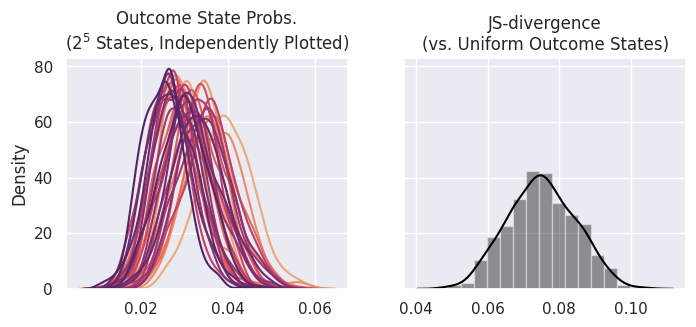

In [92]:
# Distribution of distributions.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey='row')

# Setup.
device = backends[2].backend_name
palette = sns.color_palette('flare', n_colors=2**5)
data = depth_varied_df[depth_varied_df['device'] == device]

# State distributions.
for i, state in enumerate([format(i, f'0{5}b') for i in range(2 ** 5)]):
    sns.distplot(data[state], hist=False, color=palette[i], ax=ax1)

# JS-divergence distribution.
sns.distplot(data['JS-divergence'], color='k', ax=ax2)

# Beautification.
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_title('Outcome State Probs.\n($2^5$ States, Independently Plotted)')
ax2.set_title('JS-divergence\n(vs. Uniform Outcome States)')

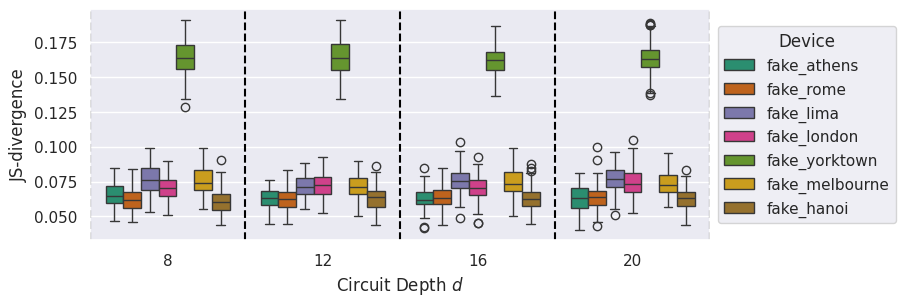

In [116]:
# JS-divergence by depth, hue on device.
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

sns.boxplot(data=depth_varied_df, x='d', y='JS-divergence', hue='device', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Device')

# Beautification.
ax.set_xlabel('Circuit Depth $d$')

# Dividing lines for clarity.
for i in range(depth_varied_df['d'].nunique() + 1):
    ax.axvline(i - .5, color='k', linestyle='--')

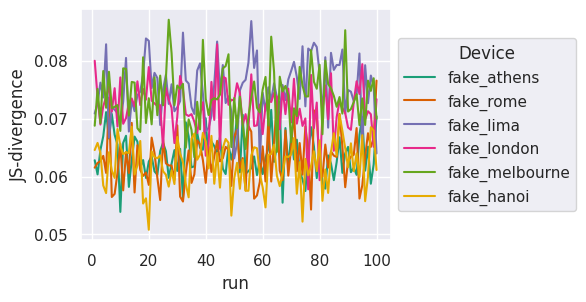

In [42]:
# JS-divergence by run, hue on device (dropping Yorktown -- it's a disaster in Yorktown).
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.lineplot(data=depth_varied_df[depth_varied_df['device'] != 'fake_yorktown'], x='run', y='JS-divergence', hue='device', ci=None, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Device')

In [121]:
# Distribution data only.
n = depth_varied_df["n"].iloc[0]
xs = depth_varied_df[[format(i, f'0{n}b') for i in range(2 ** n)]]

# Instantiate and fit a 2D PCA to the distribution data.
pca = PCA(n_components=2)
xs_pca = pca.fit_transform(xs)

# Likewise for t-SNE.
tsne = TSNE(n_components=2)
xs_tsne = tsne.fit_transform(xs)

In [122]:
# Create DataFrames for them (makes hue options easier).
pca_data = pd.DataFrame({'x' : xs_pca[:,0], 'y' : xs_pca[:,1], 'Device' : depth_varied_df['device']})
tsne_data = pd.DataFrame({'x' : xs_tsne[:,0], 'y' : xs_tsne[:,1], 'Device' : depth_varied_df['device']})

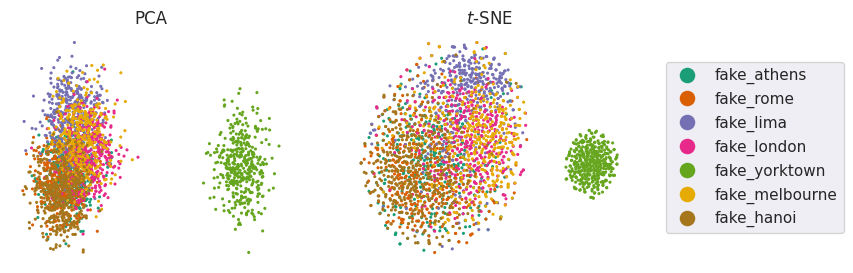

In [123]:
# Scatter plot the distributions in the reduced space (hue on machine).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
palette = 'Dark2'
size = 5
alpha = 1
plot1 = sns.scatterplot(data=pca_data, x='x', y='y', hue='Device', ax=ax1, s=size, linewidth=0, alpha=alpha, palette=palette)
plot2 = sns.scatterplot(data=tsne_data, x='x', y='y', hue='Device', ax=ax2, s=size, linewidth=0, alpha=alpha, palette=palette)

# Beautification.
ax1.set_title('PCA')
ax2.set_title('$t$-SNE')

ax1.set_axis_off()
ax2.set_axis_off()

ax1.get_legend().remove()
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5)
legend._legend_box.align = "left"

### Measurement-step

In [65]:
measurement_step_df['JS-divergence'] = measurement_step_df.apply(compute_js_div, axis=1)
measurement_step_df

,n,d,step,k,run,n_shots,device,00000,00001,00010,...,10111,11000,11001,11010,11011,11100,11101,11110,11111,JS-divergence
0,5,4,0,32,1,1000,fake_athens,0.035,0.036,0.039,...,0.023,0.033,0.030,0.024,0.032,0.024,0.028,0.025,0.021,0.063624
1,5,4,1,32,1,1000,fake_athens,0.038,0.032,0.028,...,0.034,0.036,0.028,0.029,0.027,0.029,0.028,0.029,0.031,0.060915
2,5,4,2,32,1,1000,fake_athens,0.034,0.033,0.031,...,0.026,0.026,0.030,0.032,0.034,0.028,0.026,0.034,0.019,0.052639
3,5,4,3,32,1,1000,fake_athens,0.037,0.032,0.022,...,0.034,0.021,0.034,0.035,0.027,0.036,0.026,0.029,0.028,0.048370
4,5,4,4,32,1,1000,fake_athens,0.038,0.039,0.031,...,0.018,0.025,0.036,0.021,0.031,0.027,0.037,0.027,0.029,0.070613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,5,4,28,32,100,1000,fake_hanoi,0.035,0.029,0.042,...,0.030,0.029,0.028,0.036,0.021,0.024,0.032,0.029,0.032,0.059431
3296,5,4,29,32,100,1000,fake_hanoi,0.036,0.034,0.036,...,0.040,0.033,0.029,0.031,0.022,0.023,0.031,0.035,0.035,0.062164
3297,5,4,30,32,100,1000,fake_hanoi,0.031,0.027,0.037,...,0.030,0.036,0.038,0.034,0.029,0.030,0.023,0.023,0.037,0.054263
3298,5,4,31,32,100,1000,fake_hanoi,0.039,0.031,0.030,...,0.028,0.033,0.039,0.029,0.041,0.031,0.027,0.034,0.033,0.056002


Text(0.5, 1.0, 'JS-divergence\n(vs. Uniform Outcome States)')

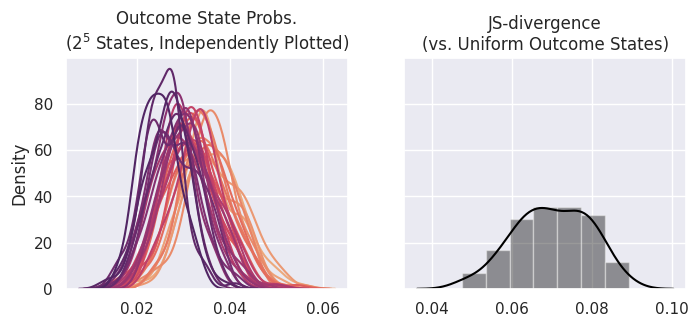

In [125]:
# Distribution of distributions.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey='row')

# Setup.
device = backends[2].backend_name
step = 0
palette = sns.color_palette('flare', n_colors=2**5)
data = measurement_step_df[(measurement_step_df['device'] == device) & (measurement_step_df['step'] == step)]

# State distributions.
for i, state in enumerate([format(i, f'0{5}b') for i in range(2 ** 5)]):
    sns.distplot(data[state], hist=False, color=palette[i], ax=ax1)

# JS-divergence distribution.
sns.distplot(data['JS-divergence'], color='k', ax=ax2)

# Beautification.
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_title('Outcome State Probs.\n($2^5$ States, Independently Plotted)')
ax2.set_title('JS-divergence\n(vs. Uniform Outcome States)')

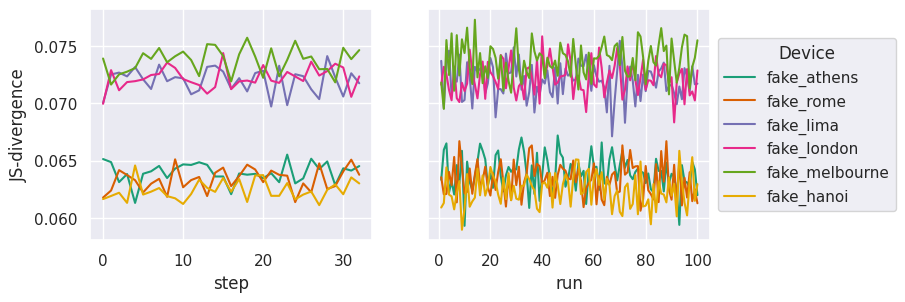

In [139]:
# JS-divergence by run and step, hue on device (dropping Yorktown -- it's a disaster in Yorktown).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey='row')

sns.lineplot(data=measurement_step_df[measurement_step_df['device'] != 'fake_yorktown'], x='step', y='JS-divergence', hue='device', ci=None, ax=ax1)
sns.lineplot(data=measurement_step_df[measurement_step_df['device'] != 'fake_yorktown'], x='run', y='JS-divergence', hue='device', ci=None, ax=ax2)
ax1.get_legend().remove()
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Device')

In [150]:
# Distribution data only.
n = measurement_step_df["n"].iloc[0]
xs = measurement_step_df[[format(i, f'0{n}b') for i in range(2 ** n)]]

# Instantiate and fit a 2D PCA to the distribution data.
pca = PCA(n_components=2)
xs_pca = pca.fit_transform(xs)

# Likewise for t-SNE. Takes ~6.5 minutes.
tsne = TSNE(n_components=2)
xs_tsne = tsne.fit_transform(xs)

In [154]:
# Create DataFrames for them (makes hue options easier).
pca_data = pd.DataFrame({'x' : xs_pca[:,0], 'y' : xs_pca[:,1], 'Device' : measurement_step_df['device'], 'Step' : measurement_step_df['step']})
tsne_data = pd.DataFrame({'x' : xs_tsne[:,0], 'y' : xs_tsne[:,1], 'Device' : measurement_step_df['device'], 'Step' : measurement_step_df['step']})

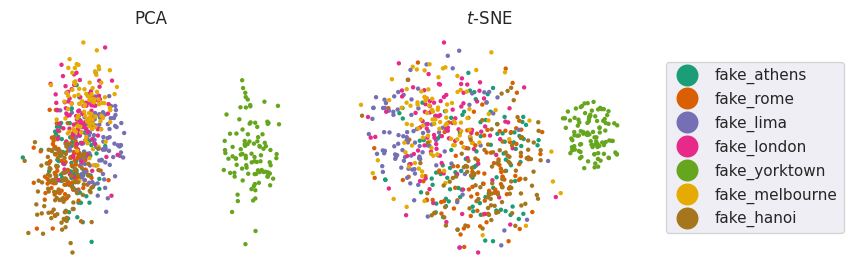

In [161]:
# Scatter plot the distributions in the reduced space (hue on machine).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
palette = 'Dark2'
size = 10
alpha = 1
step = 0
plot1 = sns.scatterplot(data=pca_data[pca_data['Step'] == step], x='x', y='y', hue='Device', ax=ax1, s=size, linewidth=0, alpha=alpha, palette=palette)
plot2 = sns.scatterplot(data=tsne_data[tsne_data['Step'] == step], x='x', y='y', hue='Device', ax=ax2, s=size, linewidth=0, alpha=alpha, palette=palette)

# Beautification.
ax1.set_title('PCA')
ax2.set_title('$t$-SNE')

ax1.set_axis_off()
ax2.set_axis_off()

ax1.get_legend().remove()
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5)
legend._legend_box.align = "left"

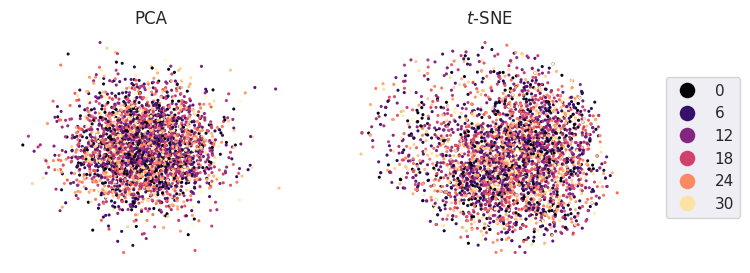

In [164]:
# Scatter plot the distributions in the reduced space (hue on machine).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
palette = 'magma'
size = 5
alpha = 1
device = backends[0].backend_name
plot1 = sns.scatterplot(data=pca_data[pca_data['Device'] == device], x='x', y='y', hue='Step', ax=ax1, s=size, linewidth=0, alpha=alpha, palette=palette)
plot2 = sns.scatterplot(data=tsne_data[tsne_data['Device'] == device], x='x', y='y', hue='Step', ax=ax2, s=size, linewidth=0, alpha=alpha, palette=palette)

# Beautification.
ax1.set_title('PCA')
ax2.set_title('$t$-SNE')

ax1.set_axis_off()
ax2.set_axis_off()

ax1.get_legend().remove()
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5)
legend._legend_box.align = "left"